# 1) Import des bibliothèques

In [397]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.getOrCreate()

path = "./data/Suicides/master.csv"
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(15,10)})

from scipy import stats
import pycountry
import geopandas
import pandas as pd


from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim 
import folium
from folium.plugins import MarkerCluster
# lecture d'un fichier de manière la plus brute



# 2) Notre DataSet


In [396]:

df = spark.read.format('csv').options(header=True).load(path)
df.toPandas()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,None,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,None,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,None,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,None,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,None,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z



# 3) Visualisations


In [409]:

data = df.select('country','year','age','suicides_no')
dataframe = data.toPandas()
dataframe['suicides_no']=dataframe['suicides_no'].astype('int')
dataframe['year']=dataframe['year'].astype('int')

sort_by_year = data.sort('year').groupBy('year').agg({'suicides_no':'sum'})
#sort_by_year.show(50)


## 3.1) Nombre de suicide global par année


### 3.1.1) Avec un histogramme

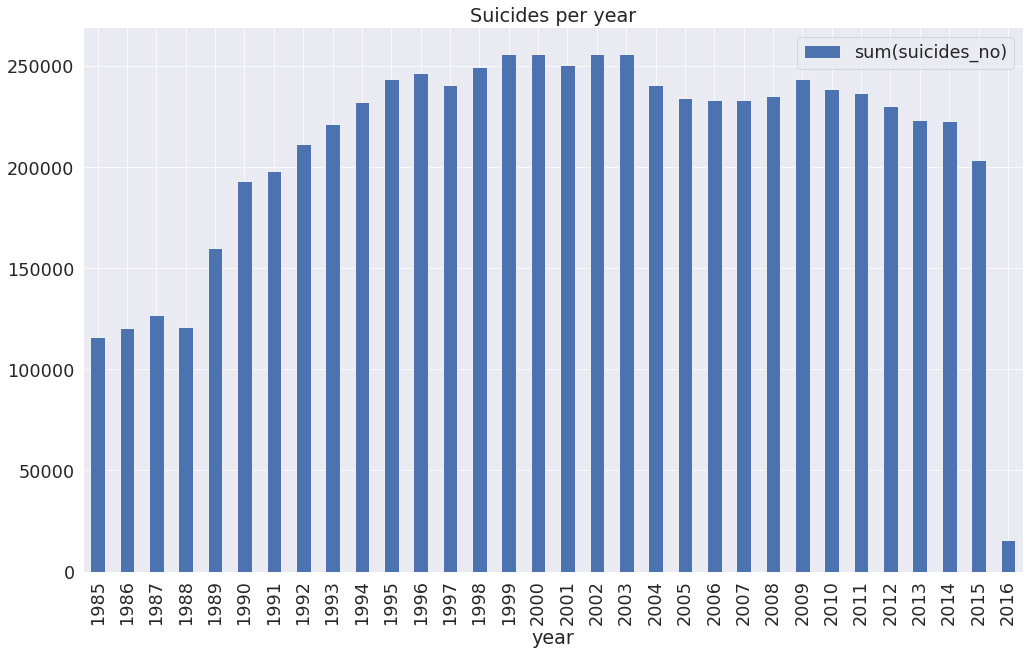

In [410]:
d = sort_by_year.toPandas()
d.plot(kind="bar", x="year", y="sum(suicides_no)", title="Suicides per year")
sns.despine()

### 3.1.2) Avec un relplot

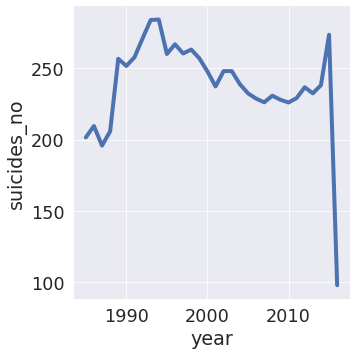

In [411]:

sns.relplot(x="year", y="suicides_no", ci=None, kind="line", data=dataframe);


# 3.2) Comparaison du nombre de suicides par sexe entre 1985 et 2016 (Lineplot)


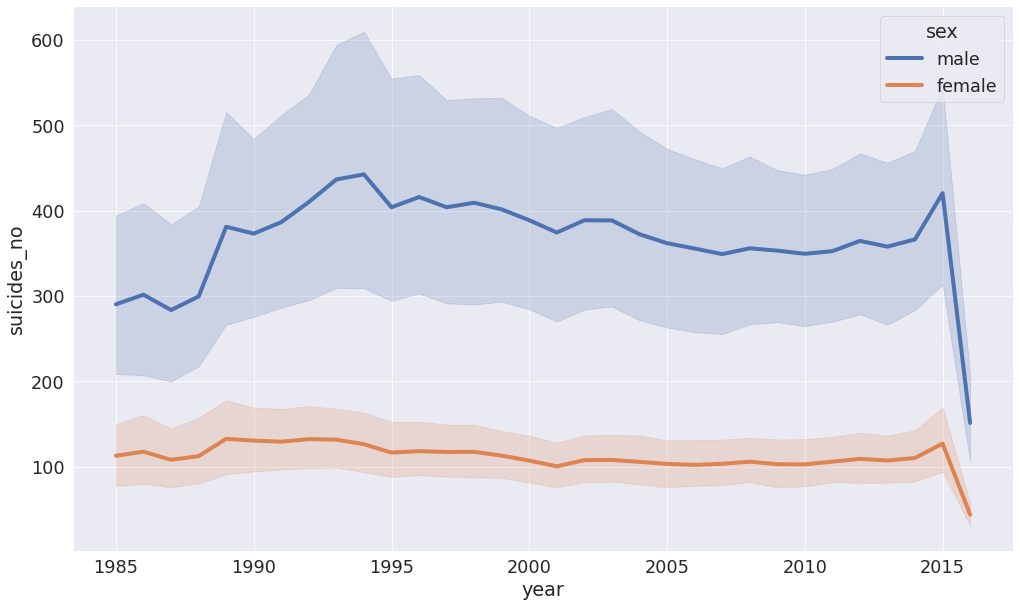

In [412]:

sort_by_sex = df.select('sex','year','suicides_no')
#sort_by_sex.show()

data_by_sex = sort_by_sex.toPandas()
data_by_sex['year'] = data_by_sex['year'].astype('int')
data_by_sex['suicides_no'] = data_by_sex['suicides_no'].astype('int')

sns.lineplot(
    data=data_by_sex,
    x="year", y="suicides_no", hue="sex",
    markers=True, dashes=False
)
sns.despine()


# 3.3) Nombre de suicides par pays (Countplot)


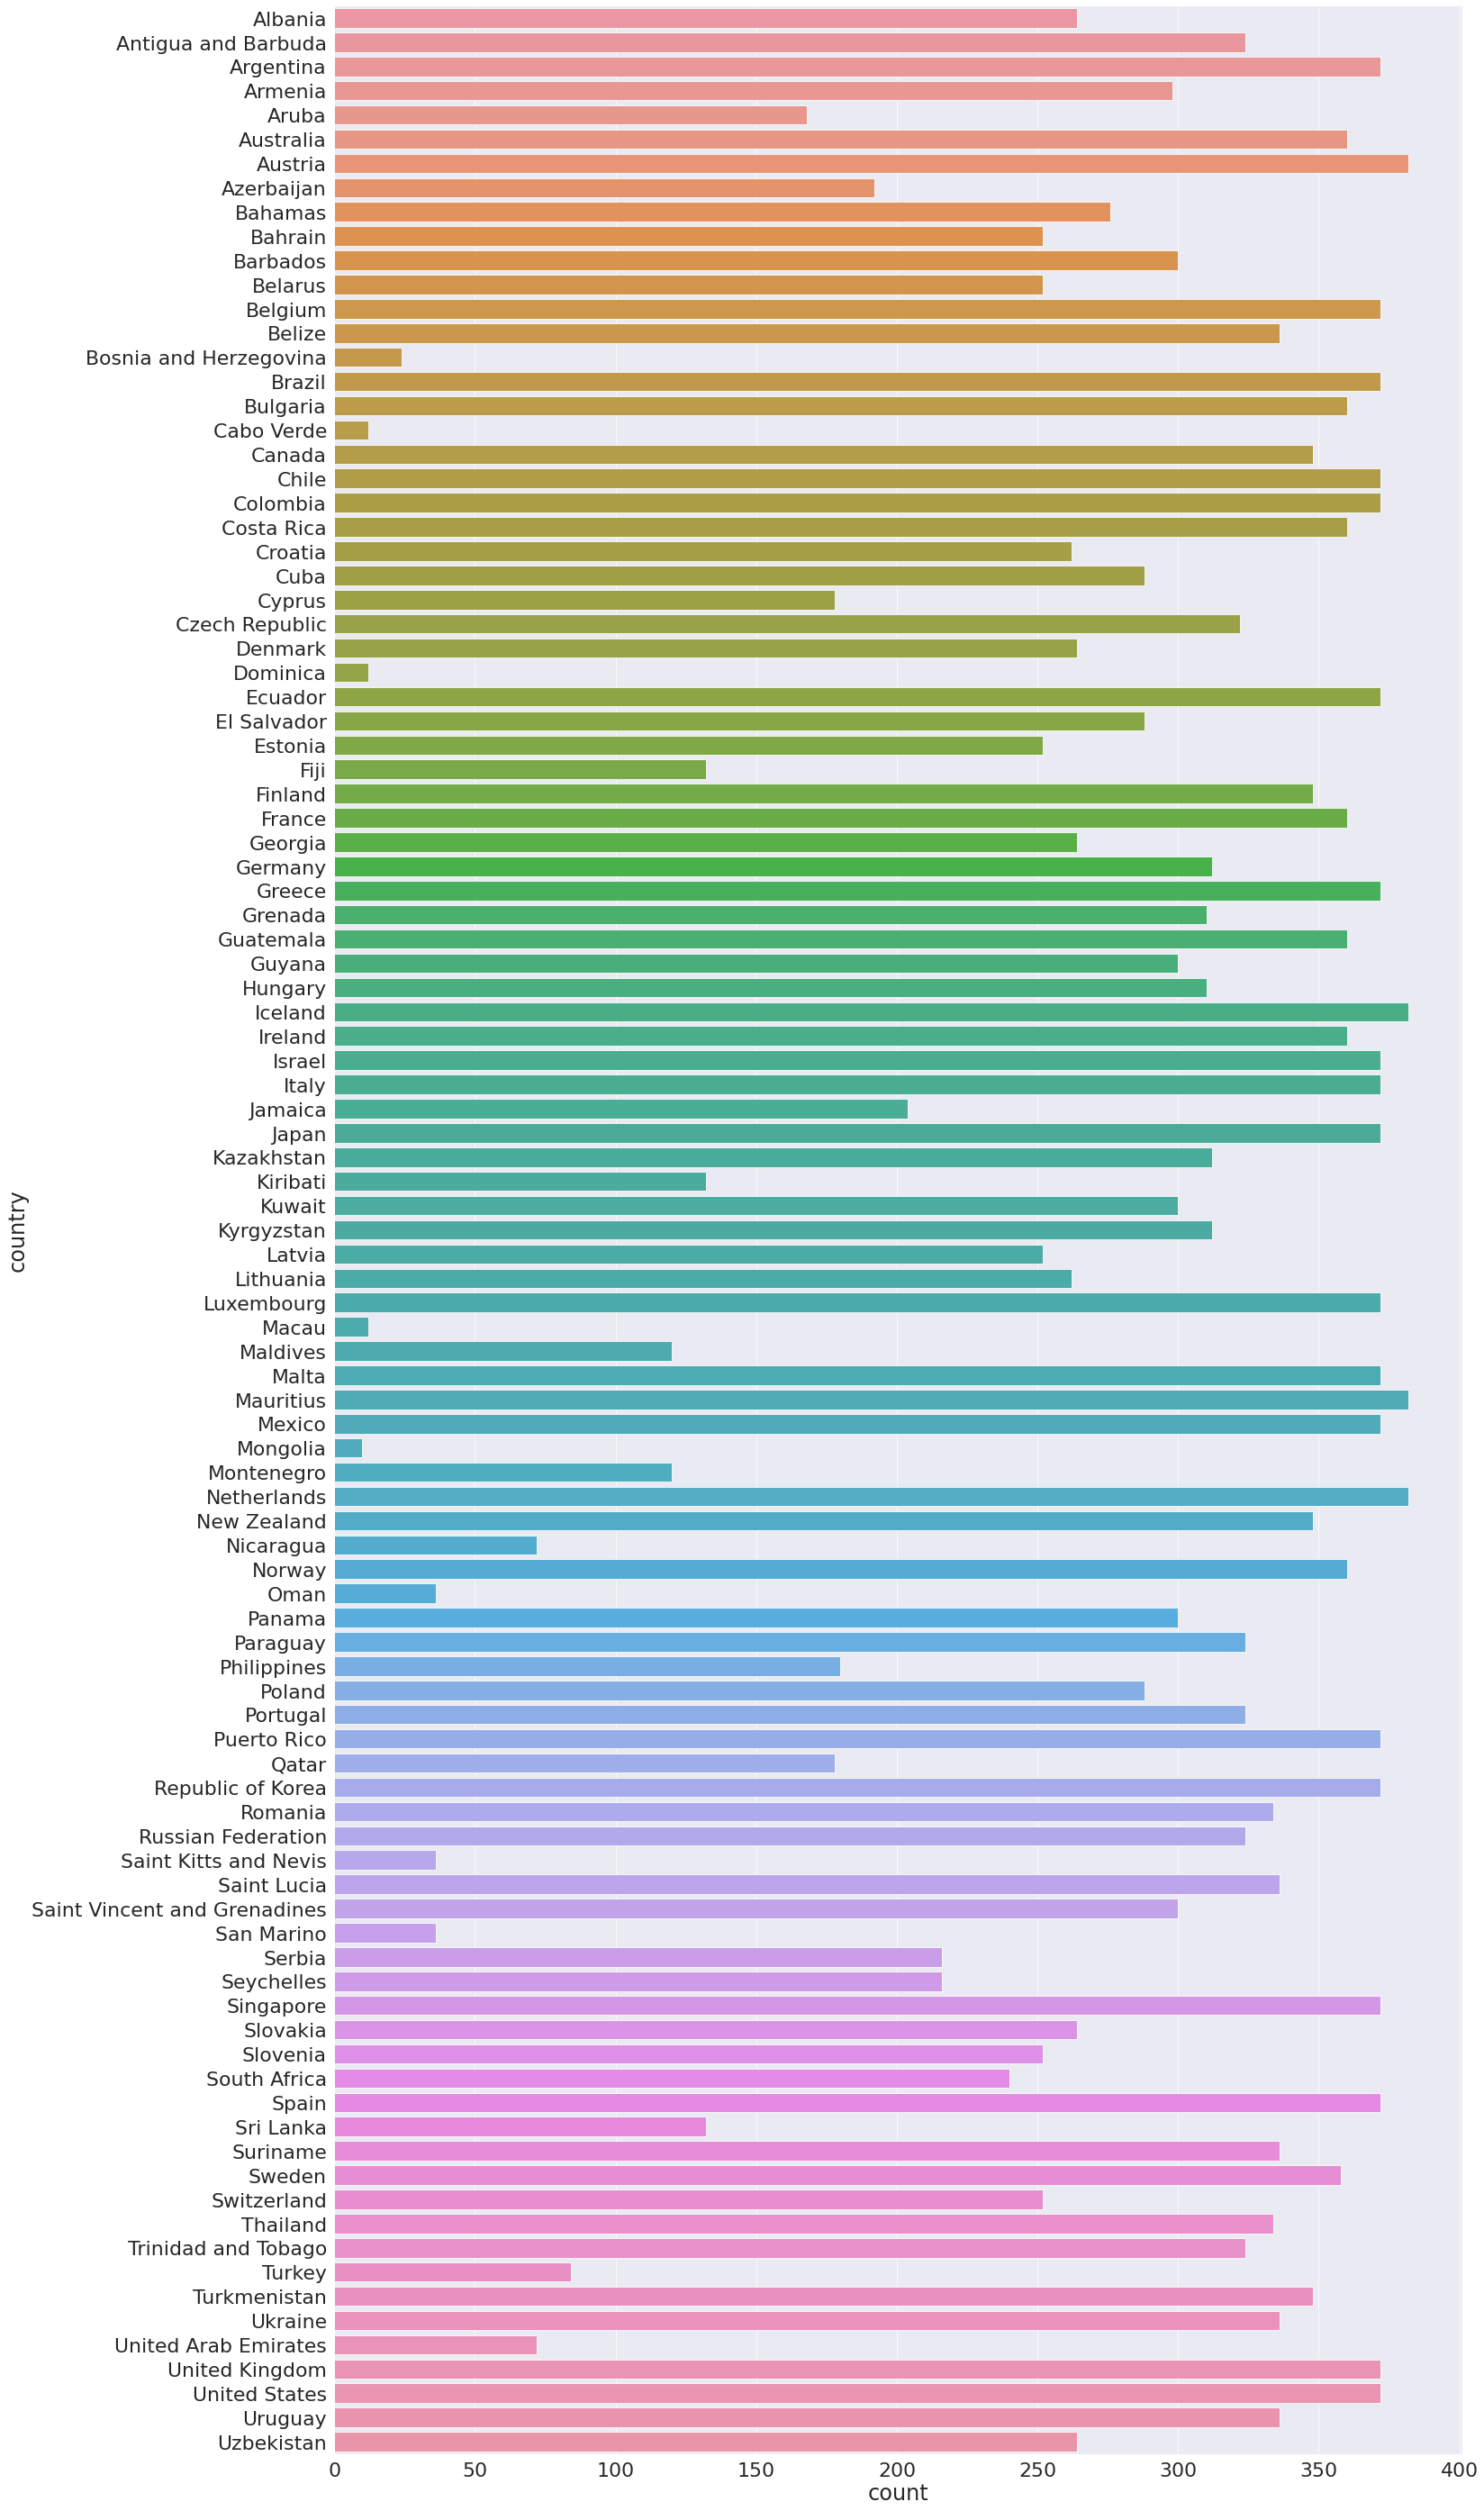

In [413]:
plt.figure(figsize=(20,50))
y = dataframe['country']
sns.set_context("paper", 2.5, {"lines.linewidth": 4})
sns.countplot(y=y,label='count')
sns.despine()


# 3.4) Nombre de suicides par tranche d'âge (10ans) (Countplot)


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


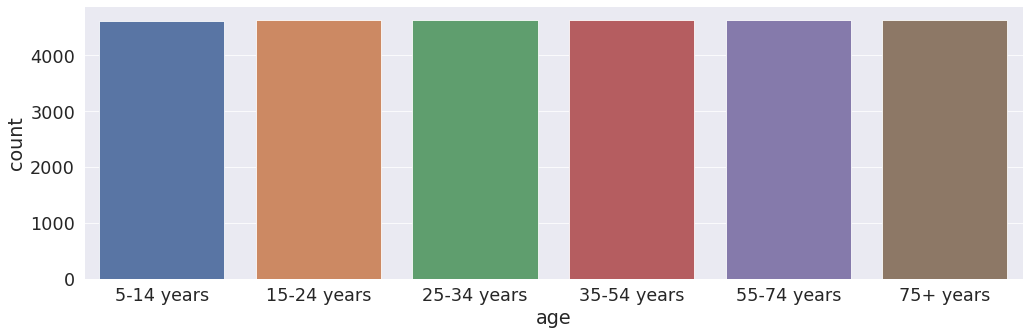

In [414]:
plt.figure(figsize=(15,5))
y = dataframe['age']
sns.set_context("paper", 2.0, {"lines.linewidth": 4})
sns.countplot(y,label='count',order=['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years'])
sns.despine()


# 3.5) Nombre de suicides par génération


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


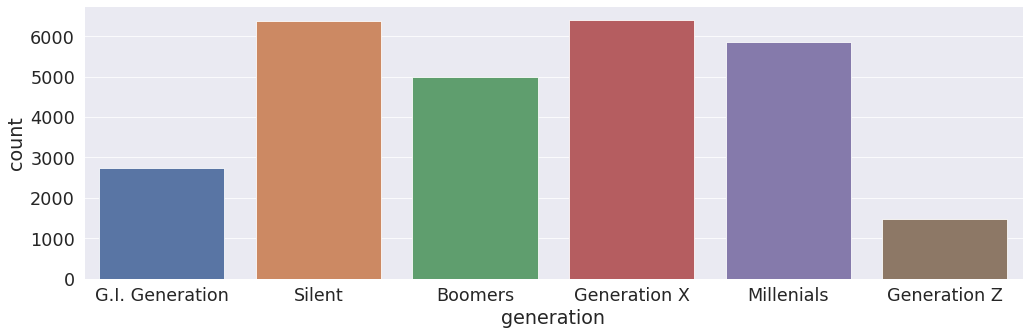

In [415]:

data= df.select('country','year','age','suicides_no','generation','sex')
dataframe = data.toPandas()
plt.figure(figsize=(15,5))
y = dataframe['generation']
sns.set_context("paper", 2.0, {"lines.linewidth": 4})
sns.countplot(y,label='generation',order=['G.I. Generation','Silent','Boomers','Generation X','Millenials','Generation Z'])
sns.despine()



# 3.6) Comparaison du nombre de suicides par sexe de chacune des années (Barplot)


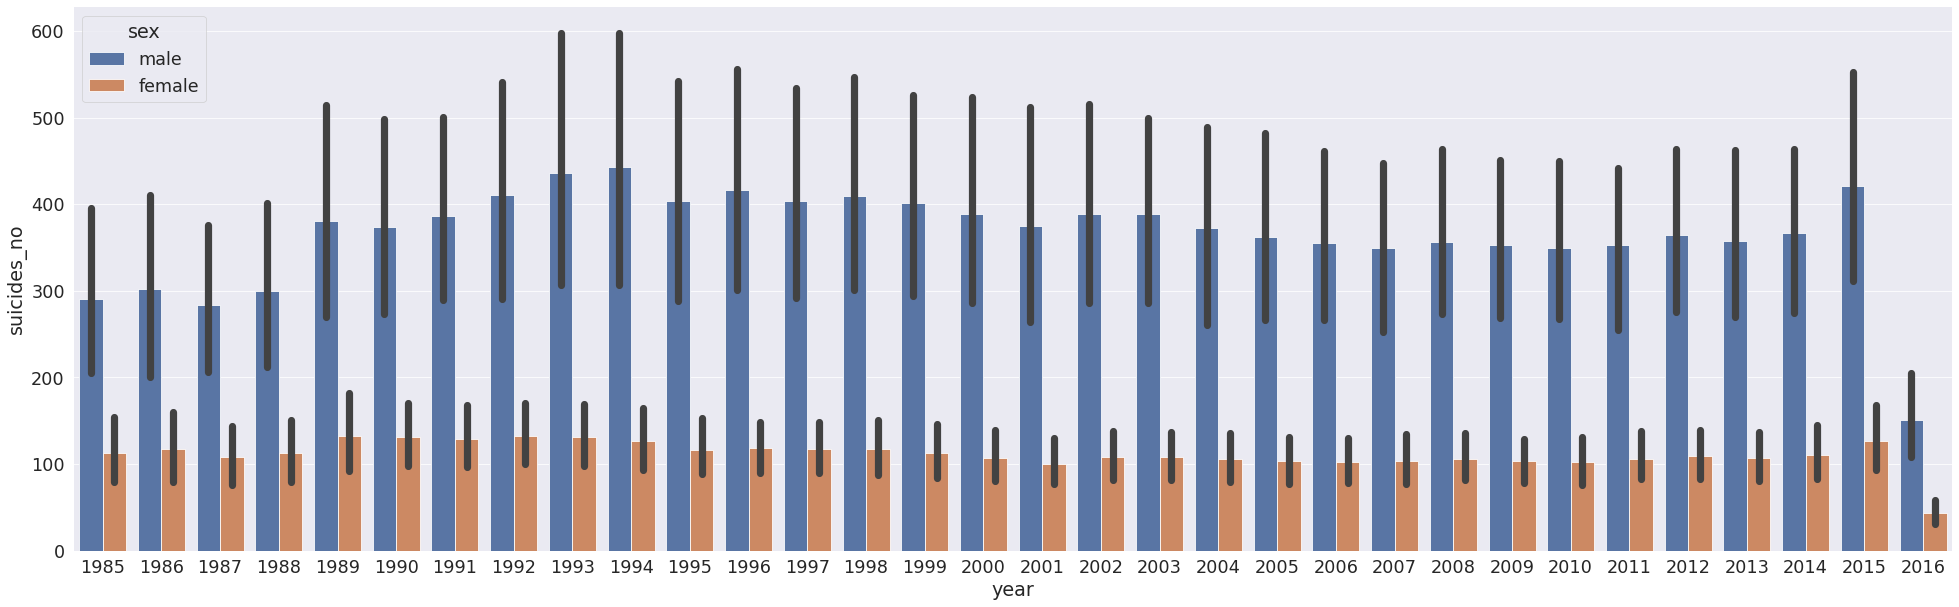

In [416]:
data= df.select('country','year','age','suicides_no','generation','sex','gdp_per_capita ($)','suicides/100k pop','HDI for year')
dataframe = data.toPandas()
dataframe['year'] = dataframe['year'].astype('int')
dataframe['suicides_no']= dataframe['suicides_no'].astype('int')
dataframe['suicides/100k pop'] = dataframe['suicides/100k pop'].astype('float')
dataframe['suicides/100k pop'] = dataframe['suicides/100k pop'].astype('int')
dataframe['suicides_no'].astype('int')
plt.figure(figsize=(30,10))
sns.set_context("paper", 2.0, {"lines.linewidth": 4})
sns.barplot(data=dataframe,x='year',y='suicides_no',hue='sex')
sns.despine()


# 3.7) Carte du monde avec le nombre de suicide dans chaque pays


In [422]:
def findGeocode(country):
    """latittude et longitude d'un pays"""
    
    try:
        geolocator = Nominatim(user_agent="default_name") 
        return geolocator.geocode(country) 
      
    except GeocoderTimedOut: 
        return findGeocode(country)

def plot_world_map():
    """la map du nombre de suicides par pays"""
    
    temp = dataframe
    ptemp = temp.groupby('country').sum()
    dtemp = ptemp.drop(['year','suicides/100k pop'],axis=1)
    dtemp.reset_index(level = ['country'],inplace=True)
    coordinates = [findGeocode(c)[1] for c in dtemp['country']]
    lat = [coor[0] for coor in coordinates]
    long = [coor[1] for coor in coordinates]
    
    """Latitudes et longitudes"""
    dtemp['latitude'] = lat
    dtemp['longitude'] = long
    
    f = folium.Figure(width=1000, height=500)

    world_map= folium.Map(tiles="cartodbpositron",max_bounds=True,zoom_control=True)
    marker_cluster = MarkerCluster().add_to(world_map)
    
    for i in range(len(dtemp)):
        lat = dtemp.iloc[i]['latitude']
        long = dtemp.iloc[i]['longitude']
        radius=5
        popup_text = """Country : {}<br> Suicides : {}<br>"""
        popup_text = popup_text.format(dtemp.iloc[i]['country'],dtemp.iloc[i]['suicides_no'])
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
        
    return world_map
plot_world_map()

# 3.8) Correlation entre le pib et le nombre de suicides

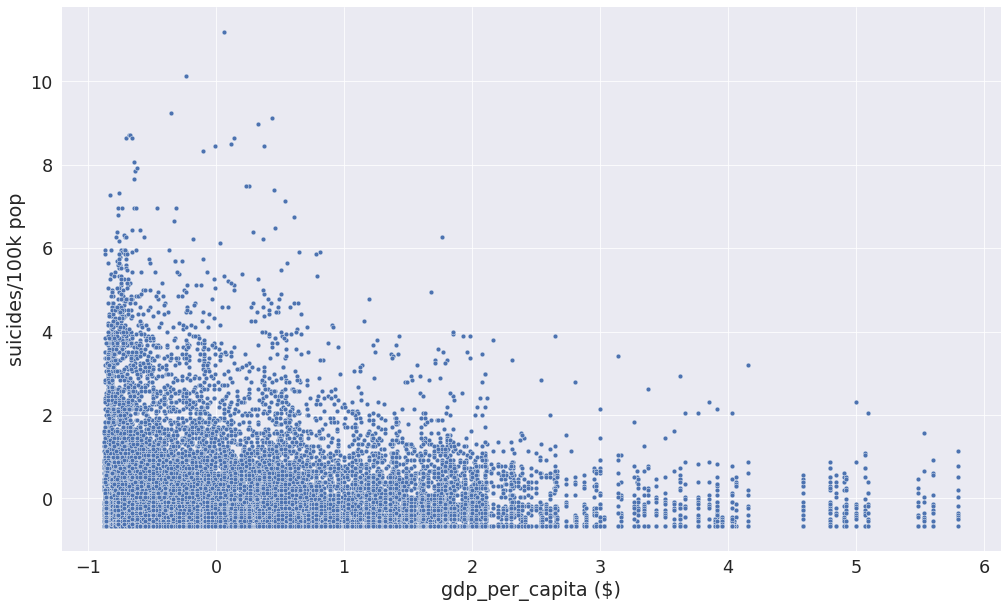

In [423]:

data_scaled = dataframe.loc[:,['gdp_per_capita ($)','suicides/100k pop']].astype('float')
data_scaled = (data_scaled - data_scaled.mean()) / data_scaled.std()
sns.scatterplot(data=data_scaled,x='gdp_per_capita ($)',y='suicides/100k pop')
sns.despine()